In [136]:
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer, TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer

from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

import string
import torch
from torch.autograd import Variable
import torch.nn.functional as F

dtype_float = torch.cuda.FloatTensor
dtype_long  = torch.cuda.LongTensor


In [137]:
all_volumes = ""
for i in range(1,8):
    with open(f"./harry_potter/Book{i}.txt", encoding='utf-8') as f:
        lines = f.readlines()
        lines = "".join(lines)
        all_volumes += lines
len(all_volumes)

6480125

In [138]:
tokenizer = TreebankWordTokenizer()

def tokenize_corpus(corpus):
    tokens = [x.split() for x in corpus]
    return tokens

def clean_corpus(corpus):
    cleaned_corpus = []
    for sentence in corpus:
        cleaned_corpus.append(word_tokenize(sentence))
    return cleaned_corpus

sentences = sent_tokenize(all_volumes)
corpus = [sentence.replace('\n','') for sentence in sentences]
tokenized_corpus = clean_corpus(corpus)
tokenized_corpus


[['/',
  'THE',
  'BOY',
  'WHO',
  'LIVED',
  'Mr.',
  'and',
  'Mrs.',
  'Dursley',
  ',',
  'of',
  'number',
  'four',
  ',',
  'Privet',
  'Drive',
  ',',
  'were',
  'proud',
  'to',
  'say',
  'that',
  'they',
  'were',
  'perfectly',
  'normal',
  ',',
  'thank',
  'you',
  'very',
  'much',
  '.'],
 ['They',
  'were',
  'the',
  'last',
  'people',
  'you',
  '’',
  'd',
  'expect',
  'to',
  'be',
  'involved',
  'in',
  'anything',
  'strange',
  'or',
  'mysterious',
  ',',
  'because',
  'they',
  'just',
  'didn',
  '’',
  't',
  'hold',
  'with',
  'such',
  'nonsense',
  '.'],
 ['Mr.',
  'Dursley',
  'was',
  'the',
  'director',
  'of',
  'a',
  'firm',
  'called',
  'Grunnings',
  ',',
  'which',
  'made',
  'drills',
  '.'],
 ['He',
  'was',
  'a',
  'big',
  ',',
  'beefy',
  'man',
  'with',
  'hardly',
  'any',
  'neck',
  ',',
  'although',
  'he',
  'did',
  'have',
  'a',
  'very',
  'large',
  'mustache',
  '.'],
 ['Mrs.',
  'Dursley',
  'was',
  'thin',
  'a

In [139]:
# stemming, stopwords removal and lemmatizing
wordnet_lemmatizer = WordNetLemmatizer()
stopword = stopwords.words('english')
snowball_stemmer = SnowballStemmer('english')

tokenized_corpus = [[(wordnet_lemmatizer.lemmatize(word.lower())) for word in sentence if word not in stopword and word.isalpha()] for sentence in tokenized_corpus]
tokenized_corpus

[['the',
  'boy',
  'who',
  'lived',
  'dursley',
  'number',
  'four',
  'privet',
  'drive',
  'proud',
  'say',
  'perfectly',
  'normal',
  'thank',
  'much'],
 ['they',
  'last',
  'people',
  'expect',
  'involved',
  'anything',
  'strange',
  'mysterious',
  'hold',
  'nonsense'],
 ['dursley', 'director', 'firm', 'called', 'grunnings', 'made', 'drill'],
 ['he',
  'big',
  'beefy',
  'man',
  'hardly',
  'neck',
  'although',
  'large',
  'mustache'],
 ['dursley',
  'thin',
  'blonde',
  'nearly',
  'twice',
  'usual',
  'amount',
  'neck',
  'came',
  'useful',
  'spent',
  'much',
  'time',
  'craning',
  'garden',
  'fence',
  'spying',
  'neighbor'],
 ['the',
  'dursley',
  'small',
  'son',
  'called',
  'dudley',
  'opinion',
  'finer',
  'boy',
  'anywhere'],
 ['the',
  'dursleys',
  'everything',
  'wanted',
  'also',
  'secret',
  'greatest',
  'fear',
  'somebody',
  'would',
  'discover'],
 ['they', 'think', 'could', 'bear', 'anyone', 'found', 'potter'],
 ['potter',


In [140]:
# building vocabulary
vocabulary = []
for sentence in tokenized_corpus:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)
            
word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

vocabulary_size = len(vocabulary)
vocabulary_size

18188

In [141]:
# build (center word, context word) pairs:
window_size = 2
idx_pairs = []

for sentence in tokenized_corpus:
    indices = [word2idx[word] for word in sentence]
    
    for center_word_pos in range(len(indices)):
        for w in range(-window_size, window_size+1):
            context_word_pos = center_word_pos + w
            
            if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
                continue
            
            idx_pairs.append((indices[center_word_pos], indices[context_word_pos]))

np.array(idx_pairs).shape
idx_pairs[:5]
# np.array([[idx2word[id] for id in sentence] for sentence in idx_pairs]).shape

# def batch(iterable, n=1):
#     l = len(iterable)
#     for ndx in range(0, l, n):
#         yield iterable[ndx:min(ndx + n, l)]

# batch_size = 64
# batched_idx_pairs = []
# for item in batch(idx_pairs, n=batch_size):
#     item.transpose()
#     batched_idx_pairs.append(item)

[(0, 1), (0, 2), (1, 0), (1, 2), (1, 3)]

In [142]:
from torch.utils.data import Dataset, DataLoader

def oneHotEncode(word_idx):
    x = torch.zeros(vocabulary_size).type(dtype_float)
    x[word_idx] = 1.0
    return x

class CorpusDataset(Dataset):
    def __init__(self, idx_pairs):
        self.center_w = []
        self.context_w = []
        
        for pair in idx_pairs:
            self.center_w.append(pair[0])
            self.context_w.append(pair[1])
        
    def __len__(self):
        return len(self.center_w)
    
    def __getitem__(self, idx):
        _w = oneHotEncode(self.center_w[idx])
        _c = oneHotEncode(self.context_w[idx])
        return _w, _c


In [143]:
device = 'cuda'
# check = torch.cuda.current_device()

# print(torch.cuda.get_device_name(check))
torch.cuda.get_device_name(torch.cuda.current_device())

'NVIDIA GeForce GTX 1660 Ti with Max-Q Design'

In [144]:
class word2vec(torch.nn.Module):
    def __init__(self, vocabulary_size, embedding_dim):
        super(word2vec, self).__init__()
        self.encode = torch.nn.Linear(vocabulary_size, embedding_dim, bias=False)
        self.decode = torch.nn.Linear(embedding_dim, vocabulary_size, bias=False)
        self.soft_max = torch.nn.LogSoftmax(dim=0)
        # self.loss = torch.nn.CrossEntropyLoss()
        
    def forward(self, center_word):
        x = self.encode(center_word)
        x = self.decode(x)
        x = self.soft_max(x)
        # loss = self.loss(context_word,x)
        return x
    
    def get_params(self):
        return self.encode._parameters['weight'], self.decode._parameters['weight']



In [145]:
len(idx_pairs)

2106944

In [146]:
trainloader = DataLoader(CorpusDataset(idx_pairs), batch_size=8056, shuffle=False)

In [147]:
embedding_dim = 64
num_epochs = 501
learning_rate = 0.001

potter2vec = word2vec(vocabulary_size, embedding_dim).cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(potter2vec.parameters(), lr=learning_rate)

writer = SummaryWriter()
trainloader_len = len(trainloader.dataset)

for epoch in tqdm(range(num_epochs)):
    e_loss = 0
    i = 0
    for idx, data in enumerate(trainloader):
        x = data[0]
        y_true = data[1]
        y = potter2vec(x)
        loss = criterion(y,y_true)
        loss.backward()
        optimizer.step()
        
        e_loss += loss.item()
        i += 1
    e_loss = e_loss/i
    writer.add_scalar('Loss/epoch_loss', e_loss, epoch)


  0%|          | 0/501 [04:10<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
W = potter2vec.get_params()[0].cpu().detach().numpy().T
C = potter2vec.get_params()[1].cpu().detach().numpy()

In [ ]:
print(W.shape)

(5079, 64)


In [ ]:
idx2word

{0: 'the',
 1: 'boy',
 2: 'who',
 3: 'lived',
 4: 'dursley',
 5: 'number',
 6: 'four',
 7: 'privet',
 8: 'drive',
 9: 'proud',
 10: 'say',
 11: 'perfectly',
 12: 'normal',
 13: 'thank',
 14: 'much',
 15: 'they',
 16: 'last',
 17: 'people',
 18: 'expect',
 19: 'involved',
 20: 'anything',
 21: 'strange',
 22: 'mysterious',
 23: 'hold',
 24: 'nonsense',
 25: 'director',
 26: 'firm',
 27: 'called',
 28: 'grunnings',
 29: 'made',
 30: 'drill',
 31: 'he',
 32: 'big',
 33: 'beefy',
 34: 'man',
 35: 'hardly',
 36: 'neck',
 37: 'although',
 38: 'large',
 39: 'mustache',
 40: 'thin',
 41: 'blonde',
 42: 'nearly',
 43: 'twice',
 44: 'usual',
 45: 'amount',
 46: 'came',
 47: 'useful',
 48: 'spent',
 49: 'time',
 50: 'craning',
 51: 'garden',
 52: 'fence',
 53: 'spying',
 54: 'neighbor',
 55: 'small',
 56: 'son',
 57: 'dudley',
 58: 'opinion',
 59: 'finer',
 60: 'anywhere',
 61: 'dursleys',
 62: 'everything',
 63: 'wanted',
 64: 'also',
 65: 'secret',
 66: 'greatest',
 67: 'fear',
 68: 'somebody',

In [ ]:
hagrid = W[word2idx['hagrid']]
hagrid

array([-0.9890538 ,  0.19080773,  1.7671194 , -0.02353713, -1.0727085 ,
       -0.3034103 , -1.9771674 , -0.31103584, -0.5987453 , -0.49258035,
       -0.0514397 , -2.1916149 , -0.01757144, -1.8588642 ,  1.138329  ,
        0.18763587, -1.2279125 , -0.9566674 ,  0.02057265,  0.33815396,
        1.5821713 ,  0.2469888 ,  0.0966187 ,  2.3054862 , -0.35775608,
        2.5989223 ,  1.6611753 , -3.062996  , -0.995128  ,  0.8047935 ,
        0.76906556,  0.746727  , -0.10518279,  0.85798013,  1.0830727 ,
        0.04344368, -0.5586466 , -1.0141683 , -0.7185671 , -0.26134035,
        1.6268849 , -0.41607076, -0.7182297 , -1.4610066 , -1.735292  ,
       -0.02823861,  0.24866328, -0.6321431 ,  0.6797431 ,  0.01380824,
        2.4085371 ,  1.6448901 ,  0.6166602 ,  0.5778829 , -1.4288114 ,
        0.39861324, -0.36286023, -2.5554667 ,  1.6687281 , -0.00892029,
       -1.8073691 , -1.2654544 ,  0.93956816,  0.55052525], dtype=float32)

In [ ]:
harry = W[word2idx['harry']]
harry

array([-1.2185404 ,  0.08371841,  1.9467001 ,  0.41920504, -1.2406704 ,
       -0.48325926, -2.0757413 , -0.08917585, -0.47245038, -0.4950932 ,
       -0.33932066, -2.3222451 ,  0.30387256, -2.1000724 ,  0.70395213,
        0.5038664 , -1.1012734 , -1.0024788 ,  0.12105478, -0.09165299,
        1.4889127 , -0.00892414,  0.10930594,  2.6509466 , -0.490763  ,
        2.6906564 ,  1.6847523 , -2.992509  , -0.565538  ,  0.5602436 ,
        0.3442798 ,  0.5302851 ,  0.31574392,  1.1845076 ,  0.94446856,
        0.02903724, -0.73031765, -0.80257773, -0.24823025, -0.13173804,
        1.7761693 , -0.4675491 , -0.45916373, -1.819824  , -1.5555081 ,
       -0.4610738 ,  0.44293034, -0.7912771 ,  0.38079858,  0.10765   ,
        2.538852  ,  1.7166446 ,  0.7021571 ,  0.92165875, -1.6737276 ,
        0.253508  ,  0.24513295, -2.6287274 ,  1.8160005 ,  0.10710765,
       -1.3851695 , -1.4103427 ,  0.4361145 ,  0.49374872], dtype=float32)

In [ ]:
dursley = W[word2idx['dursley']]
dursley

array([-0.7440593 ,  0.03037092,  1.6377224 ,  0.02460807, -1.3442742 ,
       -0.8205398 , -1.5278325 ,  0.01811364, -0.6104337 , -0.12036824,
       -0.14083938, -1.9076893 , -0.06580532, -1.4600619 ,  1.2002882 ,
        0.7405111 , -1.1480113 , -1.8528373 , -0.3341657 , -0.70220697,
        1.3317695 ,  0.4940359 ,  0.7028111 ,  2.161354  , -0.47006604,
        2.5410187 ,  1.9467475 , -2.5051162 , -1.485536  , -0.2680558 ,
        0.50891095, -0.21070518, -0.16169587,  2.0343494 ,  0.9881695 ,
       -0.38902688, -0.8011512 , -1.3367515 , -0.90912   ,  0.44012883,
        1.1322151 , -0.3476129 , -0.3848711 , -1.1434157 , -2.2367766 ,
       -0.81577176, -0.19292234, -0.66562635, -0.01526912, -0.54875946,
        2.693993  ,  1.3557991 ,  0.52382255,  1.3871964 , -0.8935374 ,
       -0.07885767,  0.51460975, -2.6058178 ,  1.244078  ,  0.4694959 ,
       -1.0426725 , -1.6050122 , -0.07455871,  1.4018514 ], dtype=float32)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from pandas.plotting import parallel_coordinates

pca = sklearnPCA(n_components=2)

transformed = pd.DataFrame(pca.fit_transform(W))
transformed = transformed.values
transformed


array([[-14.479887 ,   1.3501645],
       [-13.717717 ,   1.0596113],
       [-10.040818 ,   0.7132365],
       ...,
       [  8.020049 ,   7.519939 ],
       [ -4.080658 ,   4.91922  ],
       [ -5.9570208,  -1.441993 ]], dtype=float32)

In [ ]:
transformed[word2idx['harry']]

array([-14.355641 ,   1.3962615], dtype=float32)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


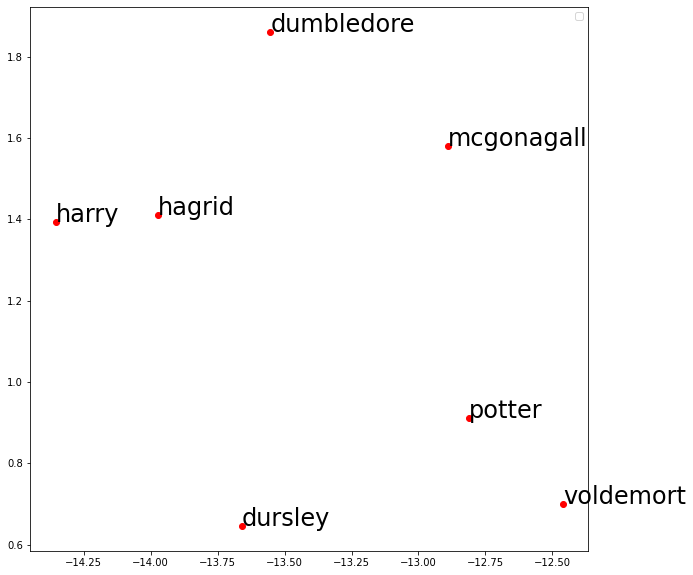

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

characters = [
    'harry',
    'potter',
    'hagrid',
    'dursley',
    'voldemort',
    'mcgonagall',
    'dumbledore'
]
for name in characters:
    plt.scatter(transformed[word2idx[name]][0], transformed[word2idx[name]][1], c='red')
    plt.text(transformed[word2idx[name]][0], transformed[word2idx[name]][1], name, fontsize=24)

plt.legend()
plt.show()